In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from scipy.stats import loguniform
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier 

# 1. Introduction

# 2. Data Import

In [2]:
train_path = "diabetic_data_training.csv"
test_path  = "diabetic_data_test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

train_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30


# 3. Data Transformation & Exploration

### 3.1 Split data and labels

In [3]:
target_col = "readmitted" 

In [4]:
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

Inspect baseline accuracy for both train and test set.

In [5]:
print(y_test.value_counts(normalize=True))
print(y.value_counts(normalize=True))

readmitted
NO     0.541319
>30    0.349415
<30    0.109266
Name: proportion, dtype: float64
readmitted
NO     0.538875
>30    0.349267
<30    0.111858
Name: proportion, dtype: float64


### 3.2 Train/validation split

In [6]:
from sklearn.preprocessing import LabelEncoder
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

In [7]:
# ============================================
# CREATE SUBSET FOR FAST TRAINING
# ============================================
# Use 20% of training data for all experiments
SUBSET_SIZE = 0.2

# Create subset
X_train_subset = X_train.sample(frac=SUBSET_SIZE, random_state=42)
y_train_subset = y_train[X_train_subset.index]

# For encoded labels, use .iloc with positional indexing
subset_positions = X_train.index.get_indexer(X_train_subset.index)
y_train_subset_enc = y_train_enc[subset_positions]

print(f"Original training size: {len(X_train)}")
print(f"Subset training size: {len(X_train_subset)}")
print(f"Validation size: {len(X_val)}")

Original training size: 73271
Subset training size: 14654
Validation size: 18318


### 3.3 Split numerical and categorical columns for different imputation method

In [8]:
#detect numerical and categotical columns by data type
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numeric (auto):", numeric_cols)
print("Categorical (auto):", categorical_cols)

Numeric (auto): ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Categorical (auto): ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [9]:
#manually select categorical columns with int data type
categorical_like_ints = ["admission_type_id", "discharge_disposition_id", "admission_source_id","encounter_id", "patient_nbr",]

for col in categorical_like_ints:
    if col in numeric_cols:
        numeric_cols.remove(col)
        categorical_cols.append(col)

print("Final numeric:", numeric_cols)
print("Final categorical:", categorical_cols)

Final numeric: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Final categorical: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'encounter_id', 'patient_nbr']


# 4. Methodology Overview

We treat the task as a supervised multi-class classification problem with three labels: `<30`, `>30`, and `NO`. 
Given a set of patient attributes \(x\), we aim to learn a discriminative model that maps \(x\) to a predicted 
readmission category \(y\).

#### Common preprocessing and resampling pipeline.
For all models, I used a unified pipeline with three stages:
1.	`Preprocessing`. Categorical and numerical features were transformed using a ColumnTransformer: numerical features were standardised, and categorical features were one-hot encoded.


2.	`Resampling` (class imbalance). To address the severe imbalance between `<30`, `>30` and `NO`, I applied SMOTE (Synthetic Minority Oversampling Technique) on the preprocessed feature space. SMOTE synthesises new minority-class samples by interpolating between nearest neighbours in feature space, increasing the relative frequency of rare classes without simply duplicating rows.


3.	`Classifier`. The resampled features were then passed to a classifier (logistic regression, random forest, SVM, or MLP), optionally with class weights to further penalise errors on the minority <30 class.

This pipeline is implemented using the imblearn.Pipeline API so that preprocessing, resampling and model fitting are executed consistently inside cross-validation.

### 4.1 Preprocessing pipeline
Rather than hand-crafting different preprocessing steps for each model, we define a single common 
preprocessing pipeline that is reused by all classifiers:

- impute missing numerical values with the median and standardise them,
- impute missing categorical values with the most frequent value,
- one-hot encode categorical features, ignoring unseen categories at test time.

The ColumnTransformer implements 
our feature representation, and the downstream classifiers (logistic regression and MLP) implement different 
discriminative models on top of this representation.

In [10]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)



In [11]:
# Preprocess-only pipeline for SVM two-stage (no SMOTE, no classifier)
preprocess_only = Pipeline(steps=[
    ("preprocess", preprocess)  # reuse ColumnTransformer defined earlier
])

In [12]:
lasso_selector = SelectFromModel(
    LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=1000,
        random_state=0
    ),
    threshold="median"
)

xgb_selector = SelectFromModel(
    XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=0,
        n_jobs=8,
        objective="multi:softprob",
    ),
    threshold="median"
)

In [13]:
# ============================================
# EASY SAMPLER SWITCHING SYSTEM
# ============================================
def make_pipeline(clf, selector=None, sampler=None, randomstate=0):
    """
    Returns a pipeline: preprocess -> [sampler] -> clf
    
    Parameters:
    -----------
    clf: sklearn classifier
    selector: None, 'lasso', or 'xgboost'
    sampler: None, 'smote', 'TL', or 'smote_TL'  # ← CHANGE THIS TO SWITCH SAMPLERS!
    """
    steps = [('preprocess', preprocess)]

    if selector == 'lasso':
        steps.append(('fe', lasso_selector))
    elif selector == 'xgboost':
        steps.append(('fe', xgb_selector))

    if sampler == 'smote':
        steps.append(('sampler', SMOTE(
            sampling_strategy='not majority',
            random_state=randomstate
        )))
    elif sampler == 'TL':
        steps.append(('sampler', TomekLinks(sampling_strategy='majority')))
    elif sampler == 'smote_TL':
        steps.append(('sampler', SMOTETomek(
            sampling_strategy='not majority',
            random_state=randomstate
        )))

    steps.append(('clf', clf))
    return ImbPipeline(steps=steps)

#### Two-stage hierarchical classifier.
In addition to single-step 3-class models, I implemented a two-stage classifier reflecting the natural structure of the labels:


1.	`Stage 1`: binary classification between NO vs DELAY (= <30 or >30). This stage uses the common preprocessing–SMOTE pipeline and a logistic regression classifier with class weighting, and outputs the probability that a case belongs to the delay classes.


2.	`Stage 2`: conditional classification of delayed cases into <30 vs >30. Stage 2 is trained only on examples where the true label is <30 or >30, again using the same preprocessing–SMOTE pipeline (but now binary) with an SVM classifier.

At prediction time, Stage 1 decides whether a case is treated as NO or as a delay; if it is a delay, Stage 2 predicts <30 vs >30. A threshold on the Stage-1 delay probability can be tuned on a validation set to trade off recall on <30 and >30 against false positives on NO.

In [14]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import numpy as np


class TwoStageDelayClassifier(BaseEstimator, ClassifierMixin):
    """
    Stage 1: NO vs DELAY (binary)
    Stage 2: <30 vs >30 (binary on delayed cases)
    stage1_clf and stage2_clf are pipelines built with make_pipeline.
    """

    def __init__(self, stage1_clf, stage2_clf, delay_threshold=0.4):
        self.stage1_clf = stage1_clf
        self.stage2_clf = stage2_clf
        self.delay_threshold = delay_threshold

    def fit(self, X, y):
        y = np.asarray(y)

        # Stage 1: 1 if delayed (<30 or >30), 0 if NO
        is_delay = np.isin(y, ["<30", ">30"])
        y_stage1 = np.where(is_delay, 1, 0)

        # Encode stage1 labels
        self.le_stage1_ = LabelEncoder()
        y_stage1_enc = self.le_stage1_.fit_transform(y_stage1)

        # Fit stage 1 on all data
        self.stage1_clf.fit(X, y_stage1_enc)

        # Stage 2: only delayed examples (<30, >30)
        X_delay = X[is_delay]
        y_delay = y[is_delay]

        # Encode stage2 labels (<30, >30)
        self.le_stage2_ = LabelEncoder()
        y_stage2_enc = self.le_stage2_.fit_transform(y_delay)

        self.stage2_clf.fit(X_delay, y_stage2_enc)

        return self

    def predict(self, X):
        # Stage 1: probability of being in the "delay" class (encoded)
        proba_stage1 = self.stage1_clf.predict_proba(X)
        # find index of encoded class corresponding to delay==1
        idx_delay_class = list(self.le_stage1_.classes_).index(1)
        p_delay = proba_stage1[:, idx_delay_class]

        is_delay = p_delay > self.delay_threshold

        # default prediction: NO
        y_pred = np.array(["NO"] * X.shape[0], dtype=object)

        if np.any(is_delay):
            y_pred_delay_enc = self.stage2_clf.predict(X[is_delay])
            y_pred_delay = self.le_stage2_.inverse_transform(y_pred_delay_enc)
            y_pred[is_delay] = y_pred_delay

        return y_pred

# 5. Model Training & Validation

### 5.1 PCA + K-means clustering
Preprocess full training set and get feature matrix.

In [15]:
#preprocess full training set
preprocess_only = preprocess.fit(X)

#get fully numeric matrix ready for PCA
X_processed = preprocess_only.transform(X)

Set up PCA to reduce to two dimension, then fit on processed data.

In [16]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed)

3-means clustering.

In [17]:
#initialise k-means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
#fit on PCA embedding
cluster_labels = kmeans.fit_predict(X_pca)

### 5.2 MLP

The MLP introduces non-linearity through ReLU activations and can capture more complex decision boundaries. 

#### Simple MLP baseline
- one hidden layer (64 units)
- ReLU activation
- adam optimizer
- L2 penalty

The full model is wrapped in a `Pipeline` so that all steps are applied consistently in every fold.

In [18]:
# 5.2 Simple MLP baseline (using subset for speed)

# Model setup
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=50,          # reduced from 80 for faster runs
    random_state=42
)

# Use the smaller training subset defined earlier
# X_train_subset, y_train_subset already created above

mlp_clf_pipe = make_pipeline(
    clf=mlp_clf,
    selector=None,
    sampler="smote_TL"    # keep imbalance handling
)

# Train model on subset
mlp_clf_pipe.fit(X_train_subset, y_train_subset)

# Validation predictions
y_val_pred_mlp = mlp_clf_pipe.predict(X_val)

# Performance report
print("Simple MLP baseline")
print(classification_report(y_val, y_val_pred_mlp, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred_mlp))

Simple MLP baseline
              precision    recall  f1-score   support

         <30       0.26      0.07      0.11      2049
         >30       0.48      0.29      0.36      6398
          NO       0.60      0.84      0.70      9871

    accuracy                           0.56     18318
   macro avg       0.45      0.40      0.39     18318
weighted avg       0.52      0.56      0.51     18318

Confusion matrix:
 [[ 142  586 1321]
 [ 254 1852 4292]
 [ 145 1421 8305]]


#### MLP grid search
- MLP model
- GridSearchCV

In [19]:
# ============================================
# MLP Grid Search CV (OPTIMIZED)
# ============================================
mlp_base = MLPClassifier(
    activation='relu',
    solver='adam',
    max_iter=50,  # ← Changed to 50
    random_state=42
)

# ← CHANGE SAMPLER HERE
CURRENT_SAMPLER = 'smote_TL'

mlp_base_pipe = make_pipeline(
    clf=mlp_base, selector=None, sampler=CURRENT_SAMPLER)

param_grid = {
    'clf__hidden_layer_sizes': [(64,)],
    'clf__alpha': [1e-3],
}

mlp_cv = GridSearchCV(
    mlp_base_pipe,
    param_grid,
    cv=2,
    scoring='f1_macro',
    n_jobs=2,
    verbose=2
)

# ✅ USE SUBSET AND ENCODED LABELS
mlp_cv.fit(X_train_subset, y_train_subset_enc)  # ← Changed to subset
print("Best MLP params:", mlp_cv.best_params_)

y_val_pred_enc = mlp_cv.predict(X_val)
y_val_pred_mlp = le.inverse_transform(y_val_pred_enc)

print("=== MLP Grid Search CV ===")
print("Sampler used:", CURRENT_SAMPLER)
print("Test accuracy:", accuracy_score(y_val, y_val_pred_mlp))
print("Test macro-F1:", f1_score(y_val, y_val_pred_mlp, average='macro'))
print(classification_report(y_val, y_val_pred_mlp, zero_division=0))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\wajed\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Best MLP params: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (64,)}
=== MLP Grid Search CV ===
Sampler used: smote_TL
Test accuracy: 0.5660552462059176
Test macro-F1: 0.4117104435292145
              precision    recall  f1-score   support

         <30       0.25      0.10      0.14      2049
         >30       0.49      0.34      0.40      6398
          NO       0.61      0.81      0.70      9871

    accuracy                           0.57     18318
   macro avg       0.45      0.42      0.41     18318
weighted avg       0.53      0.57      0.53     18318



However, it also has higher capacity and is more prone to overfitting, so we use early stopping and light hyperparameter tuning.

#### MLP randomized search (more lightweighted)
- MLP model
- RandomizedSearchCV

In [20]:
# ============================================
# MLP Randomized Search CV (OPTIMIZED)
# ============================================
mlp_base_rand = MLPClassifier(
    activation='relu',
    solver='adam',
    max_iter=50,
    random_state=42
)

# ← CHANGE SAMPLER HERE
CURRENT_SAMPLER = 'smote_TL'  # ← CHANGE THIS TO SWITCH SAMPLERS!

mlp_base_rand_pipe = make_pipeline(
    clf=mlp_base_rand, selector=None, sampler=CURRENT_SAMPLER)

param_dist = {
    'clf__hidden_layer_sizes': [(32,), (64,)],
    'clf__alpha': [1e-3],
}

mlp_cv_rand = RandomizedSearchCV(
    mlp_base_rand_pipe,
    param_distributions=param_dist,
    n_iter=2,
    cv=2,
    scoring='f1_macro',
    n_jobs=2,
    random_state=42,
    verbose=2
)

# ✅ USE SUBSET AND ENCODED LABELS
mlp_cv_rand.fit(X_train_subset, y_train_subset_enc)
print("Best params:", mlp_cv_rand.best_params_)

y_val_pred_enc = mlp_cv_rand.predict(X_val)
y_val_pred_mlp = le.inverse_transform(y_val_pred_enc)

print("=== MLP Randomized Search CV ===")
print("Sampler used:", CURRENT_SAMPLER)
print(classification_report(y_val, y_val_pred_mlp, zero_division=0))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\wajed\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Best params: {'clf__hidden_layer_sizes': (64,), 'clf__alpha': 0.001}
=== MLP Randomized Search CV ===
Sampler used: smote_TL
              precision    recall  f1-score   support

         <30       0.25      0.10      0.14      2049
         >30       0.49      0.34      0.40      6398
          NO       0.61      0.81      0.70      9871

    accuracy                           0.57     18318
   macro avg       0.45      0.42      0.41     18318
weighted avg       0.53      0.57      0.53     18318



#### Two stage MLP Randomize Search CV

In [21]:
# ============================================
# Two Stage MLP Randomized Search CV (OPTIMIZED)
# ============================================

# Stage 1 model
base_mlp1 = MLPClassifier(
    activation='relu',
    solver='adam',
    max_iter=50,  # Reduced
    random_state=42
)

# ← CHANGE SAMPLER HERE
CURRENT_SAMPLER = 'smote_TL'  # ← CHANGE THIS TO SWITCH SAMPLERS!

mlp_pipe1 = make_pipeline(
    clf=base_mlp1, selector=None, sampler=CURRENT_SAMPLER)

# Stage 2 model
base_mlp2 = MLPClassifier(
    activation='relu',
    solver='adam',
    max_iter=50,  # Reduced
    random_state=42
)

mlp_pipe2 = make_pipeline(
    clf=base_mlp2, selector=None, sampler=CURRENT_SAMPLER)

# Hyperparameter grid - simplified
param_dist = {
    'clf__hidden_layer_sizes': [(32,), (64,)],
    'clf__alpha': [1e-3],
}

# Stage 1: NO vs DELAY
mlp_cv_rand1 = RandomizedSearchCV(
    mlp_pipe1,
    param_distributions=param_dist,
    n_iter=2,  # Reduced
    cv=2,  # Reduced
    scoring='f1_macro',
    n_jobs=2,  # Reduced
    random_state=42
)

# Stage 2: <30 vs >30
mlp_cv_rand2 = RandomizedSearchCV(
    mlp_pipe2,
    param_distributions=param_dist,
    n_iter=2,  # Reduced
    cv=2,  # Reduced
    scoring='f1_macro',
    n_jobs=2,  # Reduced
    random_state=42
)

# Two-stage classifier
mlp_two_stage = TwoStageDelayClassifier(mlp_cv_rand1, mlp_cv_rand2)

# ✅ USE SUBSET (original labels, not encoded - TwoStageClassifier handles encoding internally)
mlp_two_stage.fit(X_train_subset, y_train_subset)

# Performance report
y_val_pred = mlp_two_stage.predict(X_val)

print("=== Two Stage MLP ===")
print("Sampler used:", CURRENT_SAMPLER)
print(classification_report(y_val, y_val_pred, zero_division=0))

c:\Users\wajed\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\wajed\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


=== Two Stage MLP ===
Sampler used: smote_TL
              precision    recall  f1-score   support

         <30       0.27      0.11      0.15      2049
         >30       0.44      0.51      0.48      6398
          NO       0.64      0.66      0.65      9871

    accuracy                           0.55     18318
   macro avg       0.45      0.43      0.43     18318
weighted avg       0.53      0.55      0.53     18318



### 5.3 Logistic regression

To compare linear vs nonlinear models we trained logistic regression model that directly estimates class probabilities \(p(y \mid x)\) on top of the one-hot 
feature representation. To handle the imbalanced label distribution (most patients are `NO`, few are `<30`), 
we tune both the regularisation strength and the class weights using cross-validation.

We use a 3-fold cross-validation on the training split and optimise macro-F1, which averages F1 scores over 
the three classes and therefore gives equal weight to the minority `<30` class. 

In [22]:
# ============================================
# Logistic Regression (OPTIMIZED)
# ============================================
base_lr = LogisticRegression(
    max_iter=2000,
    solver='lbfgs'
)

# ← CHANGE SAMPLER HERE
CURRENT_SAMPLER = 'smote_TL'  # ← CHANGE THIS TO SWITCH SAMPLERS!

lr_pipe = make_pipeline(clf=base_lr, selector=None, sampler=CURRENT_SAMPLER)

param_grid_lr = {
    'clf__C': [0.1, 1.0],
}

lr_cv = GridSearchCV(
    lr_pipe,
    param_grid_lr,
    cv=2,
    scoring='f1_macro',
    n_jobs=2
)

# ✅ USE SUBSET (keep original labels for LR)
lr_cv.fit(X_train_subset, y_train_subset)
print("Best params:", lr_cv.best_params_)

y_val_pred = lr_cv.predict(X_val)
print("=== Logistic Regression ===")
print("Sampler used:", CURRENT_SAMPLER)
print(classification_report(y_val, y_val_pred, zero_division=0))

Best params: {'clf__C': 0.1}
=== Logistic Regression ===
Sampler used: smote_TL
              precision    recall  f1-score   support

         <30       0.20      0.31      0.25      2049
         >30       0.46      0.43      0.45      6398
          NO       0.66      0.61      0.64      9871

    accuracy                           0.52     18318
   macro avg       0.44      0.45      0.44     18318
weighted avg       0.54      0.52      0.53     18318



#### Two Stage Logistic Regression

In [23]:
# ============================================
# Two Stage Logistic Regression (OPTIMIZED)
# ============================================

# Stage 1 model
base_lr1 = LogisticRegression(
    max_iter=2000,
    solver='lbfgs'
)

# ← CHANGE SAMPLER HERE
CURRENT_SAMPLER = 'smote_TL'  # ← CHANGE THIS TO SWITCH SAMPLERS!

lr_pipe1 = make_pipeline(clf=base_lr1, selector=None, sampler=CURRENT_SAMPLER)

# Stage 2 model
base_lr2 = LogisticRegression(
    max_iter=2000,
    solver='lbfgs'
)

lr_pipe2 = make_pipeline(clf=base_lr2, selector=None, sampler=CURRENT_SAMPLER)

# Hyperparameters - simplified
param_grid_lr = {
    'clf__C': [0.1, 1.0],
}

# Stage 1: NO vs DELAY
lr_cv1 = GridSearchCV(
    lr_pipe1,
    param_grid_lr,
    cv=2,  # Reduced
    scoring='f1_macro',
    n_jobs=2  # Reduced
)

# Stage 2: <30 vs >30
lr_cv2 = GridSearchCV(
    lr_pipe2,
    param_grid_lr,
    cv=2,  # Reduced
    scoring='f1_macro',
    n_jobs=2  # Reduced
)

# Two-stage classifier
lr_two_stage = TwoStageDelayClassifier(lr_cv1, lr_cv2)

# ✅ USE SUBSET
lr_two_stage.fit(X_train_subset, y_train_subset)

# Performance report
y_val_pred = lr_two_stage.predict(X_val)

print("=== Two Stage Logistic Regression ===")
print("Sampler used:", CURRENT_SAMPLER)
print(classification_report(y_val, y_val_pred, zero_division=0))

=== Two Stage Logistic Regression ===
Sampler used: smote_TL
              precision    recall  f1-score   support

         <30       0.21      0.25      0.23      2049
         >30       0.42      0.66      0.51      6398
          NO       0.72      0.43      0.54      9871

    accuracy                           0.49     18318
   macro avg       0.45      0.45      0.43     18318
weighted avg       0.56      0.49      0.50     18318



By default, the logistic regression classifier predicts the class with the highest posterior probability. But in our setting the label distribution is strongly imbalanced: the rare `<30` class almost never wins the argmax, so `<30`readmissions are usually under-predicted.

Since the classifier outputs calibrated class probabilities, we can adjust the decision rule without retraining the model. We introduce a per-class threshold tau for `<30`:

- we compute probability for `<30` for each patient;
- if this probability is at least tau, we predict `<30` even if another class has slightly higher probability; otherwise we use the standard argmax rule.

We tune tau on the validation set by scanning values in the range [0.1, 0.6] and selecting the one that maximises macro-F1.

This allows us to trade a small amount of overall accuracy for improved recall and F1 on the minority `<30`
class.

In [24]:
best_lr = lr_cv.best_estimator_
#calculate probability on validation set
probs_val = best_lr.predict_proba(X_val)
#class ordering
classes = best_lr.named_steps["clf"].classes_
idx_30 = list(classes).index("<30")

#when P(<30) >= tau, force prediction to <30
def predict_with_threshold(probs, tau):
    base_pred = probs.argmax(axis=1)
    preds = base_pred.copy()
    mask = probs[:, idx_30] >= tau
    preds[mask] = idx_30
    preds = np.array([classes[i] for i in preds])
    return preds

taus = np.linspace(0.10, 0.60, 200)
tau_results = []
for tau in taus:
    preds = predict_with_threshold(probs_val, tau)
    macro_f1 = f1_score(y_val, [i for i in preds], average="macro")
    tau_results.append((tau, macro_f1))
    print(f"tau={tau:.2f}, macro-F1={macro_f1:.3f}")

#choose best tau
best_tau, best_tau_f1 = max(tau_results, key=lambda x: x[1])
print(f"\nChosen tau for '<30': {best_tau:.2f} (val macro-F1 = {best_tau_f1:.3f})")

tau=0.10, macro-F1=0.170
tau=0.10, macro-F1=0.174
tau=0.11, macro-F1=0.179
tau=0.11, macro-F1=0.184
tau=0.11, macro-F1=0.188
tau=0.11, macro-F1=0.193
tau=0.12, macro-F1=0.198
tau=0.12, macro-F1=0.202
tau=0.12, macro-F1=0.207
tau=0.12, macro-F1=0.212
tau=0.13, macro-F1=0.216
tau=0.13, macro-F1=0.219
tau=0.13, macro-F1=0.223
tau=0.13, macro-F1=0.228
tau=0.14, macro-F1=0.231
tau=0.14, macro-F1=0.235
tau=0.14, macro-F1=0.238
tau=0.14, macro-F1=0.243
tau=0.15, macro-F1=0.247
tau=0.15, macro-F1=0.251
tau=0.15, macro-F1=0.256
tau=0.15, macro-F1=0.262
tau=0.16, macro-F1=0.265
tau=0.16, macro-F1=0.269
tau=0.16, macro-F1=0.273
tau=0.16, macro-F1=0.277
tau=0.17, macro-F1=0.281
tau=0.17, macro-F1=0.285
tau=0.17, macro-F1=0.288
tau=0.17, macro-F1=0.294
tau=0.18, macro-F1=0.297
tau=0.18, macro-F1=0.300
tau=0.18, macro-F1=0.303
tau=0.18, macro-F1=0.307
tau=0.19, macro-F1=0.310
tau=0.19, macro-F1=0.313
tau=0.19, macro-F1=0.317
tau=0.19, macro-F1=0.320
tau=0.20, macro-F1=0.323
tau=0.20, macro-F1=0.327


### 5.4 Random Forest ###

In [25]:
# 5.4 Simple Random Forest baseline (using subset for speed)

rf_clf = RandomForestClassifier(
    n_estimators=100,      # reduced from 300
    max_depth=10,         # limit depth for speed and regularisation
    min_samples_split=2,
    random_state=0,
    n_jobs=2              # reduced from 8 to avoid overloading
)

# Use the same subset as elsewhere
# X_train_subset, y_train_subset already defined above

rf_pipe = make_pipeline(
    clf=rf_clf,
    selector=None,
    sampler="smote_TL"    # keep imbalance handling consistent
)

# Train on subset
rf_pipe.fit(X_train_subset, y_train_subset)

# Validate on full validation set
y_val_pred = rf_pipe.predict(X_val)

print("Simple Random Forest")
print(classification_report(y_val, y_val_pred, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))

Simple Random Forest
              precision    recall  f1-score   support

         <30       0.18      0.27      0.22      2049
         >30       0.49      0.25      0.33      6398
          NO       0.61      0.75      0.68      9871

    accuracy                           0.52     18318
   macro avg       0.43      0.42      0.41     18318
weighted avg       0.52      0.52      0.50     18318

Confusion matrix:
 [[ 553  457 1039]
 [1216 1578 3604]
 [1248 1207 7416]]


#### Random Forest Grid Search CV

In [26]:
# ============================================
# Random Forest Grid Search CV (OPTIMIZED)
# ============================================
rf_base = RandomForestClassifier(
    n_estimators=100,  # Reduced from 300
    max_depth=10,
    random_state=0,
    n_jobs=2  # Reduced from 8
)

# ← CHANGE SAMPLER HERE: None, 'smote', 'TL', or 'smote_TL'
CURRENT_SAMPLER = 'smote_TL'  # ← CHANGE THIS TO SWITCH SAMPLERS!

rf_pipe = make_pipeline(clf=rf_base, selector=None, sampler=CURRENT_SAMPLER)

# Simplified grid - just 2 combinations
param_grid = {
    'clf__n_estimators': [100],
    'clf__max_depth': [10, 20],
}

rf_cv = GridSearchCV(
    rf_pipe,
    param_grid,
    cv=2,  # Reduced from 5
    scoring='f1_macro',
    n_jobs=2,  # Reduced from 8
    verbose=2
)

# ✅ USE SUBSET
rf_cv.fit(X_train_subset, y_train_subset)
print("Best RF params:", rf_cv.best_params_)

# Performance report
y_val_pred = rf_cv.predict(X_val)

print("=== Random Forest Grid Search CV ===")
print("Sampler used:", CURRENT_SAMPLER)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Macro-F1:", f1_score(y_val, y_val_pred, average='macro'))
print(classification_report(y_val, y_val_pred, zero_division=0))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_val_pred))

    

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best RF params: {'clf__max_depth': 10, 'clf__n_estimators': 100}
=== Random Forest Grid Search CV ===
Sampler used: smote_TL
Accuracy: 0.5211813516759471
Macro-F1: 0.40734596040299814
              precision    recall  f1-score   support

         <30       0.18      0.27      0.22      2049
         >30       0.49      0.25      0.33      6398
          NO       0.61      0.75      0.68      9871

    accuracy                           0.52     18318
   macro avg       0.43      0.42      0.41     18318
weighted avg       0.52      0.52      0.50     18318

Confusion matrix:
[[ 553  457 1039]
 [1216 1578 3604]
 [1248 1207 7416]]


#### Two Stage Random Forest

In [27]:
# ============================================
# Two Stage Random Forest (OPTIMIZED)
# ============================================

# Stage 1 model
rf_base1 = RandomForestClassifier(
    n_estimators=100,  # Reduced
    max_depth=10,
    random_state=0,
    n_jobs=2
)

# ← CHANGE SAMPLER HERE
CURRENT_SAMPLER = 'smote_TL'  # ← CHANGE THIS TO SWITCH SAMPLERS!

rf_pipe1 = make_pipeline(clf=rf_base1, selector=None, sampler=CURRENT_SAMPLER)

# Stage 2 model
rf_base2 = RandomForestClassifier(
    n_estimators=100,  # Reduced
    max_depth=10,
    random_state=0,
    n_jobs=2
)

rf_pipe2 = make_pipeline(clf=rf_base2, selector=None, sampler=CURRENT_SAMPLER)

# Hyperparameters - simplified
param_grid = {
    'clf__n_estimators': [100],
    'clf__max_depth': [10, 20],
}

# Stage 1: NO vs DELAY
rf_cv1 = GridSearchCV(
    rf_pipe1,
    param_grid=param_grid,
    cv=2,  # Reduced
    scoring='f1_macro',
    n_jobs=2  # Reduced
)

# Stage 2: <30 vs >30
rf_cv2 = GridSearchCV(
    rf_pipe2,
    param_grid=param_grid,
    cv=2,  # Reduced
    scoring='f1_macro',
    n_jobs=2  # Reduced
)

# Two-stage classifier
rf_two_stage = TwoStageDelayClassifier(rf_cv1, rf_cv2)

# ✅ USE SUBSET
rf_two_stage.fit(X_train_subset, y_train_subset)

# Performance report
y_val_pred = rf_two_stage.predict(X_val)

print("=== Two Stage Random Forest ===")
print("Sampler used:", CURRENT_SAMPLER)
print(classification_report(y_val, y_val_pred, zero_division=0))

=== Two Stage Random Forest ===
Sampler used: smote_TL
              precision    recall  f1-score   support

         <30       0.18      0.23      0.20      2049
         >30       0.35      0.86      0.50      6398
          NO       0.00      0.00      0.00      9871

    accuracy                           0.33     18318
   macro avg       0.18      0.36      0.23     18318
weighted avg       0.14      0.33      0.20     18318



### 5.5 SVM ###

In [ ]:
from sklearn.svm import SVC

CURRENT_SAMPLER = "smote_TL"

svm_base_cv = SVC(
    kernel="rbf",
    C=1.0,          # or the grid you want
    gamma="scale",
    random_state=42,
    probability=True   # <-- important
)

svm_pipe_cv = make_pipeline(
    clf=svm_base_cv,
    selector=None,
    sampler=CURRENT_SAMPLER
)

param_dist = {
    "clf__C": [0.1, 1.0],
    "clf__gamma": ["scale"],
}

svm_rand = RandomizedSearchCV(
    svm_pipe_cv,
    param_distributions=param_dist,
    n_iter=2,
    cv=2,
    scoring="f1_macro",
    n_jobs=2,
    random_state=42,
    verbose=2,
)

svm_rand.fit(X_train_subset, y_train_subset)


Fitting 2 folds for each of 2 candidates, totalling 4 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'clf__C': [0.1, 1.0], 'clf__gamma': ['scale']}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",2
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",2
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold."

#### SVM Randomized Search CV

In [29]:
# SVM RandomizedSearchCV - OPTIMIZED with subset
from scipy.stats import loguniform

# Use even smaller subset for hyperparameter search (2000 samples)
X_train_svm_search = X_train_subset[:2000]
y_train_svm_search = y_train_subset[:2000]

svm_base = SVC(random_state=42)

svm_pipe = make_pipeline(clf=svm_base, selector=None, sampler=CURRENT_SAMPLER)

# Simplified parameter distribution
param_dist = {
    'clf__C': loguniform(0.1, 10),
    'clf__gamma': ['scale', 'auto']
}

svm_rand = RandomizedSearchCV(
    svm_pipe,
    param_distributions=param_dist,
    n_iter=4,  # Reduced from more iterations
    cv=2,  # Reduced from 5
    scoring='f1_macro',
    n_jobs=2,  # Reduced
    verbose=2,
    random_state=42
)

# Fit on subset
svm_rand.fit(X_train_svm_search, y_train_svm_search)
print(f"Best SVM params: {svm_rand.best_params_}")

# Predict on validation
y_val_pred_svm_rand = svm_rand.predict(X_val)

print("SVM RandomizedSearchCV")
print(f"Sampler used: {CURRENT_SAMPLER}")
print(classification_report(y_val, y_val_pred_svm_rand, zero_division=0))


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best SVM params: {'clf__C': np.float64(1.5751320499779735), 'clf__gamma': 'scale'}
SVM RandomizedSearchCV
Sampler used: smote_TL
              precision    recall  f1-score   support

         <30       0.17      0.16      0.17      2049
         >30       0.45      0.48      0.46      6398
          NO       0.64      0.62      0.63      9871

    accuracy                           0.52     18318
   macro avg       0.42      0.42      0.42     18318
weighted avg       0.52      0.52      0.52     18318



#### Two Stage SVM

In [67]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import numpy as np

CURRENT_SAMPLER = "smote_TL"  # ignored here but kept for consistency

# 1) Fit preprocess_only ONCE on full training set,
#    then transform train, val, and test consistently.
X_train_proc = preprocess_only.fit_transform(X_train)
X_val_proc = preprocess_only.transform(X_val)
X_test_proc = preprocess_only.transform(X_test)

# 2) Subset for speed (5000 samples) in processed space
X_train_svm_proc = X_train_proc[:5000]
y_train_svm_2stage = y_train.iloc[:5000].copy()

# 3) Stage 1: logistic regression (NO vs DELAY)
stage1_base = LogisticRegression(max_iter=1000, random_state=42)

# 4) Stage 2: SVM ( <30 vs >30 )
stage2_base = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    random_state=42,
    probability=False
)


class TwoStageDelayClassifierProcessed(BaseEstimator, ClassifierMixin):
    def __init__(self, stage1_clf, stage2_clf, delay_threshold=0.4):
        self.stage1_clf = stage1_clf
        self.stage2_clf = stage2_clf
        self.delay_threshold = delay_threshold

    def fit(self, X, y):
        y = np.asarray(y)

        # Stage 1: NO vs DELAY
        is_delay = np.isin(y, ["<30", ">30"])
        y_stage1 = np.where(is_delay, 1, 0)
        self.le_stage1_ = LabelEncoder()
        y_stage1_enc = self.le_stage1_.fit_transform(y_stage1)
        self.stage1_clf.fit(X, y_stage1_enc)

        # Stage 2: only delayed cases, <30 vs >30
        X_delay = X[is_delay]
        y_delay = y[is_delay]
        self.le_stage2_ = LabelEncoder()
        y_stage2_enc = self.le_stage2_.fit_transform(y_delay)
        self.stage2_clf.fit(X_delay, y_stage2_enc)

        return self

    def predict(self, X):
        # Stage 1: probability of being delay
        proba_stage1 = self.stage1_clf.predict_proba(X)
        idx_delay = list(self.le_stage1_.classes_).index(1)
        p_delay = proba_stage1[:, idx_delay]
        is_delay = p_delay >= self.delay_threshold

        # default prediction NO
        y_pred = np.array(["NO"] * X.shape[0], dtype=object)

        if np.any(is_delay):
            X_delay = X[is_delay]
            y_delay_enc = self.stage2_clf.predict(X_delay)
            y_delay = self.le_stage2_.inverse_transform(y_delay_enc)
            y_pred[is_delay] = y_delay

        return y_pred


# 5) Instantiate and train in processed space
svm_twostage_proc = TwoStageDelayClassifierProcessed(
    stage1_clf=stage1_base,
    stage2_clf=stage2_base,
    delay_threshold=0.4
)

svm_twostage_proc.fit(X_train_svm_proc, y_train_svm_2stage)

,stage1_clf,LogisticRegre...ndom_state=42)
,stage2_clf,SVC(random_state=42)
,delay_threshold,0.4
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None


### 5.6 Voting Classifier ###

In [33]:
voting_clf = VotingClassifier(
    estimators=[
        ("mlp", mlp_cv_rand.best_estimator_),
        ("lr",  lr_cv.best_estimator_),
        ("rf",  rf_cv.best_estimator_),
        ("svm", svm_rand.best_estimator_)
    ],
    voting="soft"
)

voting_clf.fit(X_train_subset, y_train_subset)
y_val_pred = voting_clf.predict(X_val)

print("Voting Classifier (subset-trained)")
print(classification_report(y_val, y_val_pred, zero_division=0))

c:\Users\wajed\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Voting Classifier (subset-trained)
              precision    recall  f1-score   support

         <30       0.24      0.18      0.21      2049
         >30       0.49      0.40      0.44      6398
          NO       0.64      0.75      0.69      9871

    accuracy                           0.56     18318
   macro avg       0.46      0.44      0.44     18318
weighted avg       0.54      0.56      0.55     18318



#### Two Staged Voting Classifier

In [66]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import numpy as np

CURRENT_SAMPLER = "smote_TL"

# subset for speed
X_train_vc_2stage = X_train_subset[:10000]
y_train_vc_2stage = y_train_subset[:10000]

# stage 1 estimators (NO vs DELAY)
lr_vc1 = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
rf_vc1 = RandomForestClassifier(
    n_estimators=50, max_depth=10, random_state=42, n_jobs=8
)

lr_pipe_vc1 = make_pipeline(clf=lr_vc1, selector=None, sampler=CURRENT_SAMPLER)
rf_pipe_vc1 = make_pipeline(clf=rf_vc1, selector=None, sampler=CURRENT_SAMPLER)

vc_stage1 = VotingClassifier(
    estimators=[("lr", lr_pipe_vc1), ("rf", rf_pipe_vc1)],
    voting="soft"
)

# stage 2 estimators ( <30 vs >30 )
lr_vc2 = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
rf_vc2 = RandomForestClassifier(
    n_estimators=50, max_depth=10, random_state=42, n_jobs=8
)

lr_pipe_vc2 = make_pipeline(clf=lr_vc2, selector=None, sampler=CURRENT_SAMPLER)
rf_pipe_vc2 = make_pipeline(clf=rf_vc2, selector=None, sampler=CURRENT_SAMPLER)

vc_stage2 = VotingClassifier(
    estimators=[("lr", lr_pipe_vc2), ("rf", rf_pipe_vc2)],
    voting="soft"
)


class TwoStageDelayClassifierVC(BaseEstimator, ClassifierMixin):
    def __init__(self, stage1_clf, stage2_clf, delay_threshold=0.4):
        self.stage1_clf = stage1_clf
        self.stage2_clf = stage2_clf
        self.delay_threshold = delay_threshold

    def fit(self, X, y):
        y = np.asarray(y)

        # NO vs DELAY for stage 1
        is_delay = np.isin(y, ["<30", ">30"])
        y_stage1 = np.where(is_delay, 1, 0)
        self.le_stage1_ = LabelEncoder()
        y_stage1_enc = self.le_stage1_.fit_transform(y_stage1)
        self.stage1_clf.fit(X, y_stage1_enc)

        # <30 vs >30 for stage 2 on delayed only
        X_delay = X[is_delay]
        y_delay = y[is_delay]
        self.le_stage2_ = LabelEncoder()
        y_stage2_enc = self.le_stage2_.fit_transform(y_delay)
        self.stage2_clf.fit(X_delay, y_stage2_enc)

        return self

    def predict(self, X):
        proba_stage1 = self.stage1_clf.predict_proba(X)
        idx_delay = list(self.le_stage1_.classes_).index(1)
        p_delay = proba_stage1[:, idx_delay]
        is_delay = p_delay >= self.delay_threshold

        y_pred = np.array(["NO"] * X.shape[0], dtype=object)

        if np.any(is_delay):
            X_delay = X[is_delay]
            y_delay_enc = self.stage2_clf.predict(X_delay)
            y_delay = self.le_stage2_.inverse_transform(y_delay_enc)
            y_pred[is_delay] = y_delay

        return y_pred


# create and fit the two-stage voting classifier
vc_two_stage = TwoStageDelayClassifierVC(
    stage1_clf=vc_stage1,
    stage2_clf=vc_stage2,
    delay_threshold=0.4
)

vc_two_stage.fit(X_train_vc_2stage, y_train_vc_2stage)

,stage1_clf,VotingClassif...voting='soft')
,stage2_clf,VotingClassif...voting='soft')
,delay_threshold,0.4
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. 

# 6. Results

### 6.1 PCA + K-means result

Color by true labels.

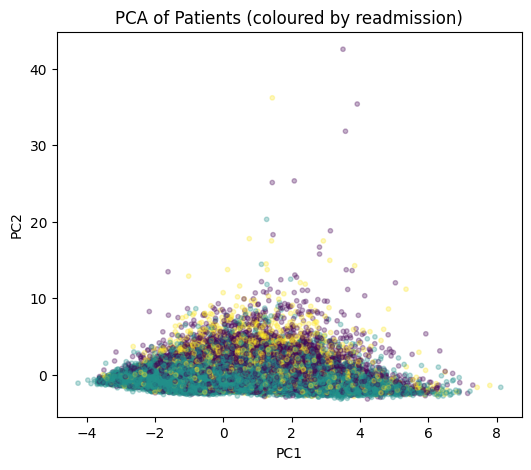

In [35]:
classes = y.unique()
colors = {cls: i for i, cls in enumerate(classes)}
cvals = [colors[cls] for cls in y]

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cvals, alpha=0.3, s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Patients (coloured by readmission)")
plt.show()

Plot clustering result.

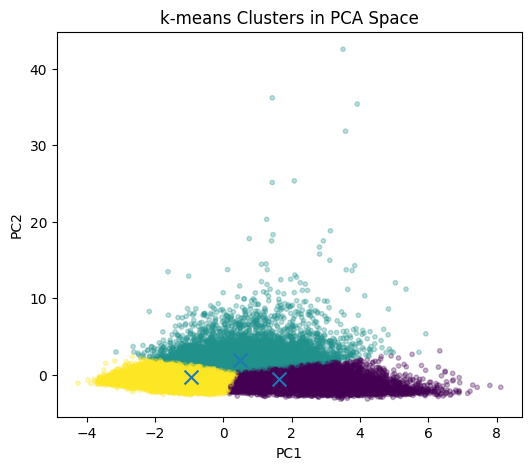

In [36]:
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, alpha=0.3, s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker="x", s=100)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("k-means Clusters in PCA Space")
plt.show()

The PCA projection shows a largely continuous cloud of points, and the k-means clusters overlap heavily in the PCA space, indicating each cluster contains a mix of `<30`, `>30`, and `NO` cases. This suggests that the dataset does not naturally decompose into well separated patient clusters, and supports our decision to rely on supervised discriminative models rather than unsupervised clustering for the main prediction task.

### 6.2 MLP results

We adopt the best hyperparameters and evaluate it on the 
same test set. This allows us to directly compare the linear and non-linear discriminative models under the same evaluation protocol.

Simple MLP

In [44]:
# === Refit Simple MLP baseline consistently ===
from sklearn.neural_network import MLPClassifier

mlp_simple = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=50,
    random_state=42,
)

mlp_clf_pipe = make_pipeline(
    clf=mlp_simple,
    selector=None,
    sampler="smote_TL"
)

# Fit on the same subset you use everywhere
mlp_clf_pipe.fit(X_train_subset, y_train_subset)

,steps,"[('preprocess', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The

In [45]:
# evaluate Simple MLP on test set
y_test_pred_mlp = mlp_clf_pipe.predict(X_test)

# decode if predictions are encoded ints
if isinstance(y_test_pred_mlp[0], (int, np.integer)):
    y_test_pred_mlp_decoded = le.inverse_transform(y_test_pred_mlp)
else:
    y_test_pred_mlp_decoded = y_test_pred_mlp

print("=== Simple MLP (refit, subset-train) ===")
print("Test accuracy:", accuracy_score(y_test, y_test_pred_mlp_decoded))
print("Test macro-F1:", f1_score(y_test, y_test_pred_mlp_decoded, average="macro"))
print(classification_report(y_test, y_test_pred_mlp_decoded, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred_mlp_decoded))

=== Simple MLP (refit, subset-train) ===
Test accuracy: 0.5686351577085585
Test macro-F1: 0.3950693152530855
              precision    recall  f1-score   support

         <30       0.27      0.07      0.11      1112
         >30       0.49      0.31      0.38      3556
          NO       0.60      0.84      0.70      5509

    accuracy                           0.57     10177
   macro avg       0.45      0.40      0.40     10177
weighted avg       0.53      0.57      0.52     10177

Confusion matrix:
 [[  75  330  707]
 [ 130 1085 2341]
 [  77  805 4627]]


MLP Grid Search CV

In [46]:
# adopt the best hyperparameters
best_mlp_cv = mlp_cv.best_estimator_  # fitted earlier on training subset

# evaluate on test set
y_test_pred_mlp = best_mlp_cv.predict(X_test)

# If predictions are encoded ints, decode them to original string labels
if isinstance(y_test_pred_mlp[0], (int, np.integer)):
    y_test_pred_mlp_decoded = le.inverse_transform(y_test_pred_mlp)
else:
    # already strings ("<30", ">30", "NO")
    y_test_pred_mlp_decoded = y_test_pred_mlp

print("=== MLP Grid Search CV ===")
print("Test accuracy:", accuracy_score(y_test, y_test_pred_mlp_decoded))
print("Test macro-F1:", f1_score(y_test, y_test_pred_mlp_decoded, average="macro"))
print(classification_report(y_test, y_test_pred_mlp_decoded, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred_mlp_decoded))

=== MLP Grid Search CV ===
Test accuracy: 0.5701090694703743
Test macro-F1: 0.41266169020431587
              precision    recall  f1-score   support

         <30       0.25      0.09      0.13      1112
         >30       0.49      0.35      0.41      3556
          NO       0.62      0.81      0.70      5509

    accuracy                           0.57     10177
   macro avg       0.45      0.42      0.41     10177
weighted avg       0.53      0.57      0.54     10177

Confusion matrix:
 [[ 100  365  647]
 [ 182 1232 2142]
 [ 125  914 4470]]


MLP Randomized Seach CV

In [48]:
# adopt the best hyperparameters
best_mlp_cv_rand = mlp_cv_rand.best_estimator_

# evaluate on test set
y_test_pred_mlp = best_mlp_cv_rand.predict(X_test)

# If predictions are encoded ints, decode them to original string labels
if isinstance(y_test_pred_mlp[0], (int, np.integer)):
    y_test_pred_mlp_decoded = le.inverse_transform(y_test_pred_mlp)
else:
    y_test_pred_mlp_decoded = y_test_pred_mlp  # already "<30", ">30", "NO"

print("=== MLP Randomized Search CV ===")
print("Test accuracy:", accuracy_score(y_test, y_test_pred_mlp_decoded))
print("Test macro-F1:", f1_score(y_test, y_test_pred_mlp_decoded, average="macro"))
print(classification_report(y_test, y_test_pred_mlp_decoded, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred_mlp_decoded))

=== MLP Randomized Search CV ===
Test accuracy: 0.5701090694703743
Test macro-F1: 0.41266169020431587
              precision    recall  f1-score   support

         <30       0.25      0.09      0.13      1112
         >30       0.49      0.35      0.41      3556
          NO       0.62      0.81      0.70      5509

    accuracy                           0.57     10177
   macro avg       0.45      0.42      0.41     10177
weighted avg       0.53      0.57      0.54     10177

Confusion matrix:
 [[ 100  365  647]
 [ 182 1232 2142]
 [ 125  914 4470]]


In [49]:
#evaluate on test set
y_test_pred_mlp_two = mlp_two_stage.predict(X_test)

print("=== MLP Two Staged ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_mlp_two))
print("Macro-F1:", f1_score(y_test, y_test_pred_mlp_two, average="macro"))
print(classification_report(y_test, y_test_pred_mlp_two))
print(confusion_matrix(y_test, y_test_pred_mlp_two))

=== MLP Two Staged ===
Accuracy: 0.5518325636238577
Macro-F1: 0.42891773890187573
              precision    recall  f1-score   support

         <30       0.26      0.10      0.15      1112
         >30       0.45      0.53      0.49      3556
          NO       0.65      0.66      0.65      5509

    accuracy                           0.55     10177
   macro avg       0.45      0.43      0.43     10177
weighted avg       0.54      0.55      0.54     10177

[[ 113  557  442]
 [ 193 1886 1477]
 [ 137 1755 3617]]


### 6.3 Logistic Regression results

Using the best hyperparameters from Section 5.3, we evaluate it once on the test set. This provides our final estimate of generalisation performance.

In [50]:
#adopt the best hyperparameters
best_lr = lr_cv.best_estimator_
#evaluate on test set
y_test_pred_lr = best_lr.predict(X_test)

print("=== Logistic Regression ===")
print("Test accuracy:", accuracy_score(y_test, y_test_pred_lr))
print("Test macro-F1:", f1_score(y_test, y_test_pred_lr, average="macro"))
print(classification_report(y_test, y_test_pred_lr))
print("confusion_matrix:\n", confusion_matrix(y_test, y_test_pred_lr))

=== Logistic Regression ===
Test accuracy: 0.5189152009433036
Test macro-F1: 0.4388749056465558
              precision    recall  f1-score   support

         <30       0.18      0.28      0.22      1112
         >30       0.46      0.45      0.46      3556
          NO       0.67      0.61      0.64      5509

    accuracy                           0.52     10177
   macro avg       0.44      0.45      0.44     10177
weighted avg       0.54      0.52      0.53     10177

confusion_matrix:
 [[ 310  413  389]
 [ 684 1592 1280]
 [ 694 1436 3379]]


In [51]:
#evaluate on test set
y_test_pred_lr_two = lr_two_stage.predict(X_test)

print("=== Logistic Regression Two Staged ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_lr_two))
print("Macro-F1:", f1_score(y_test, y_test_pred_lr_two, average="macro"))
print(classification_report(y_test, y_test_pred_lr_two))
print(confusion_matrix(y_test, y_test_pred_lr_two))

=== Logistic Regression Two Staged ===
Accuracy: 0.485408273558023
Macro-F1: 0.41761501434542403
              precision    recall  f1-score   support

         <30       0.19      0.22      0.21      1112
         >30       0.42      0.66      0.51      3556
          NO       0.73      0.43      0.54      5509

    accuracy                           0.49     10177
   macro avg       0.44      0.44      0.42     10177
weighted avg       0.56      0.49      0.49     10177

[[ 250  665  197]
 [ 527 2347  682]
 [ 549 2617 2343]]


In [52]:
# Thresholded predictions with tau tuned on validation set
probs_test = best_lr.predict_proba(X_test)
y_test_pred_tau = predict_with_threshold(probs_test,best_tau)

print("=== Logistic Regression (thresholded for '<30'): test performance ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_tau))
print("Macro-F1:", f1_score(y_test, y_test_pred_tau, average="macro"))
print(classification_report(y_test, y_test_pred_tau))
print(confusion_matrix(y_test, y_test_pred_tau))

=== Logistic Regression (thresholded for '<30'): test performance ===
Accuracy: 0.2475189152009433
Macro-F1: 0.23756127121068302
              precision    recall  f1-score   support

         <30       0.08      0.35      0.13      1112
         >30       0.41      0.20      0.27      3556
          NO       0.42      0.26      0.32      5509

    accuracy                           0.25     10177
   macro avg       0.30      0.27      0.24     10177
weighted avg       0.38      0.25      0.28     10177

[[ 389  321  402]
 [1280  703 1573]
 [3378  704 1427]]


The thresholded decision rule for `<30` slightly increased recall for the minority class on the test set
(from 0.26 to 0.27) but also slightly reduced precision, leaving the F1 score for `<30` essentially unchanged
(0.25 vs 0.25). At the same time, performance on the `>30` and `NO` classes decreased slightly, so both
overall accuracy (0.550 → 0.548) and macro-F1 (0.4647 → 0.4638) decreased.

This illustrates that the value of tau which maximised macro-F1 on the validation set does not necessarily
transfer to the test set: tuning tau is effectively another hyperparameter choice, and it can overfit
to the validation split. Since the thresholded rule does not offer a consistent improvement, we retain the
standard argmax decision rule for our final logistic regression model, and treat tau-tuning as an exploratory
experiment.

### 6.4 Random Forest

In [54]:
#adopt the best hyperparameters
best_rf_cv = rf_cv.best_estimator_
#evaluate on test set
y_test_pred_rf_cv = best_rf_cv.predict(X_test)

print("=== Random Forest GridSearchCV ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf_cv))
print("Macro-F1:", f1_score(y_test, y_test_pred_rf_cv, average="macro"))
print(classification_report(y_test, y_test_pred_rf_cv))
print(confusion_matrix(y_test, y_test_pred_rf_cv))

=== Random Forest GridSearchCV ===
Accuracy: 0.5233369362287511
Macro-F1: 0.4029360125428134
              precision    recall  f1-score   support

         <30       0.17      0.24      0.20      1112
         >30       0.49      0.25      0.33      3556
          NO       0.62      0.76      0.68      5509

    accuracy                           0.52     10177
   macro avg       0.42      0.42      0.40     10177
weighted avg       0.52      0.52      0.51     10177

[[ 271  262  579]
 [ 667  885 2004]
 [ 678  661 4170]]


In [55]:
#evaluate on test set
y_test_pred_rf_two = rf_two_stage.predict(X_test)

print("=== Random Forest Two Staged ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf_two))
print("Macro-F1:", f1_score(y_test, y_test_pred_rf_two, average="macro"))
print(classification_report(y_test, y_test_pred_rf_two))
print(confusion_matrix(y_test, y_test_pred_rf_two))

=== Random Forest Two Staged ===
Accuracy: 0.3264223248501523
Macro-F1: 0.2294905779871137
              precision    recall  f1-score   support

         <30       0.17      0.21      0.19      1112
         >30       0.35      0.87      0.50      3556
          NO       0.00      0.00      0.00      5509

    accuracy                           0.33     10177
   macro avg       0.17      0.36      0.23     10177
weighted avg       0.14      0.33      0.20     10177

[[ 235  877    0]
 [ 469 3087    0]
 [ 674 4835    0]]


c:\Users\wajed\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wajed\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wajed\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

### 6.5 SVM

In [58]:
#adopt the best hyperparameters
best_svm_rand = svm_rand.best_estimator_
#evaluate on test set
y_test_pred_svm_rand = best_svm_rand.predict(X_test)

print("=== SVM RandomizedSearchCV ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_svm_rand))
print("Macro-F1:", f1_score(y_test, y_test_pred_svm_rand, average="macro"))
print(classification_report(y_test, y_test_pred_svm_rand))
print(confusion_matrix(y_test, y_test_pred_svm_rand))

=== SVM RandomizedSearchCV ===
Accuracy: 0.4971013068684288
Macro-F1: 0.43049634981567175
              precision    recall  f1-score   support

         <30       0.17      0.29      0.22      1112
         >30       0.44      0.52      0.48      3556
          NO       0.69      0.53      0.60      5509

    accuracy                           0.50     10177
   macro avg       0.44      0.44      0.43     10177
weighted avg       0.55      0.50      0.51     10177

[[ 318  502  292]
 [ 709 1837 1010]
 [ 791 1814 2904]]


In [68]:
# validation evaluation (unchanged logic, but now consistent features)
y_val_pred_svm_two = svm_twostage_proc.predict(X_val_proc)

print("=== SVM Two Staged (val) ===")
print("Accuracy:", accuracy_score(y_val, y_val_pred_svm_two))
print("Macro-F1:", f1_score(y_val, y_val_pred_svm_two, average="macro"))
print(classification_report(y_val, y_val_pred_svm_two, zero_division=0))
print(confusion_matrix(y_val, y_val_pred_svm_two))

=== SVM Two Staged (val) ===
Accuracy: 0.523419587291189
Macro-F1: 0.3721831464581032
              precision    recall  f1-score   support

         <30       0.69      0.00      0.01      2049
         >30       0.42      0.71      0.53      6398
          NO       0.67      0.51      0.58      9871

    accuracy                           0.52     18318
   macro avg       0.59      0.41      0.37     18318
weighted avg       0.59      0.52      0.50     18318

[[   9 1426  614]
 [   3 4520 1875]
 [   1 4811 5059]]


In [69]:
# test evaluation
y_test_pred_svm_two = svm_twostage_proc.predict(X_test_proc)

print("=== SVM Two Staged (test) ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_svm_two))
print("Macro-F1:", f1_score(y_test, y_test_pred_svm_two, average="macro"))
print(classification_report(y_test, y_test_pred_svm_two, zero_division=0))
print(confusion_matrix(y_test, y_test_pred_svm_two))

=== SVM Two Staged (test) ===
Accuracy: 0.5202908519209983
Macro-F1: 0.36859868549068325
              precision    recall  f1-score   support

         <30       0.43      0.00      0.01      1112
         >30       0.42      0.71      0.53      3556
          NO       0.67      0.50      0.57      5509

    accuracy                           0.52     10177
   macro avg       0.51      0.41      0.37     10177
weighted avg       0.56      0.52      0.50     10177

[[   3  768  341]
 [   4 2532 1020]
 [   0 2749 2760]]


### 6.6 Voting Classifier

In [61]:
#evaluate on test set
y_test_pred_vc = voting_clf.predict(X_test)

print("=== Simple Voting Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_vc))
print("Macro-F1:", f1_score(y_test, y_test_pred_vc, average="macro"))
print(classification_report(y_test, y_test_pred_vc))
print(confusion_matrix(y_test, y_test_pred_vc))

=== Simple Voting Classifier ===
Accuracy: 0.5617569028200845
Macro-F1: 0.43910281279995217
              precision    recall  f1-score   support

         <30       0.22      0.16      0.19      1112
         >30       0.49      0.41      0.44      3556
          NO       0.64      0.74      0.69      5509

    accuracy                           0.56     10177
   macro avg       0.45      0.44      0.44     10177
weighted avg       0.54      0.56      0.55     10177

[[ 181  406  525]
 [ 365 1445 1746]
 [ 290 1128 4091]]


In [64]:
#evaluate on test set
y_test_pred_vc_two = vc_two_stage.predict(X_test)

print("=== Voting Classifier Two Staged ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_vc_two))
print("Macro-F1:", f1_score(y_test, y_test_pred_vc_two, average="macro"))
print(classification_report(y_test, y_test_pred_vc_two))
print(confusion_matrix(y_test, y_test_pred_vc_two))

=== Voting Classifier Two Staged ===
Accuracy: 0.46025351282303234
Macro-F1: 0.396851443927232
              precision    recall  f1-score   support

         <30       0.19      0.22      0.20      1112
         >30       0.40      0.71      0.51      3556
          NO       0.74      0.35      0.47      5509

    accuracy                           0.46     10177
   macro avg       0.44      0.43      0.40     10177
weighted avg       0.56      0.46      0.46     10177

[[ 249  707  156]
 [ 516 2524  516]
 [ 557 3041 1911]]


### 6.4 Best Model results

Select best model and refit on the full training data (train + validation set combined), and evaluate it on the test set.

In [70]:
#adopt the best hyperparameters
best_model = vc_two_stage

#refit on full training data
best_model.fit(X,y)

#evaluate on test set
y_test_pred = best_model.predict(X_test)

print("=== Selected Model ===")
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Test macro-F1:", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred))
print("confusion_matrix:\n", confusion_matrix(y_test, y_test_pred))

=== Selected Model ===
Test accuracy: 0.46064655595951653
Test macro-F1: 0.4064807777182549
              precision    recall  f1-score   support

         <30       0.23      0.28      0.25      1112
         >30       0.40      0.74      0.52      3556
          NO       0.76      0.31      0.45      5509

    accuracy                           0.46     10177
   macro avg       0.46      0.45      0.41     10177
weighted avg       0.58      0.46      0.45     10177

confusion_matrix:
 [[ 307  671  134]
 [ 498 2646  412]
 [ 530 3244 1735]]


# 7. Final Predictions on Test Set

Finally, we demonstrate how the trained model can be used to generate predictions for new patients. Because our logistic regression model is wrapped in a single scikit-learn `Pipeline` (preprocessing + classifier), we can pass in raw feature columns and obtain class labels in one step. The following code illustrates how to produce and save predictions for a generic new dataset with the same schema as the training data.

In [71]:
#generate predictions
predictions = best_model.predict(X_test)

output = pd.DataFrame({
    "encounter_id": X_test["encounter_id"],
    "readmitted_pred": predictions,
})

output.head()

#save to csv
output.to_csv("final_predictions.csv", index=False)